In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
df = pd.read_csv('reviews_data.csv').dropna()
unbalanced = pd.read_csv('unbalanced_review_data.csv').dropna()

In [19]:
df = df[['star_rating', 'review_body']]
unbalanced = unbalanced[['star_rating', 'review_body']]

In [20]:
df.head()

,star_rating,review_body
0,5,This is the best stuff ever!! It cleans pet st...
1,5,I will never buy another soap again. I use th...
2,5,"works great, helps alot with smelly dog breath..."
3,5,The perfect device for a new technology
4,5,You're looking up books like this and reading ...


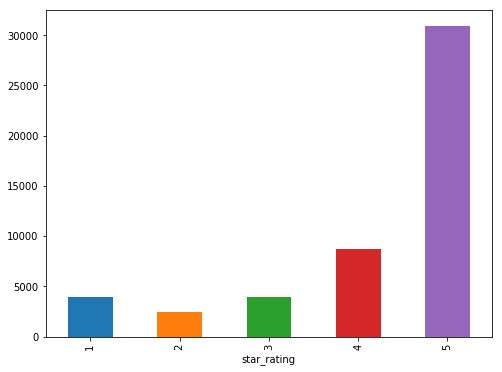

In [7]:
fig = plt.figure(figsize=(8,6))
unbalanced.groupby('star_rating').review_body.count().plot.bar()
plt.show()

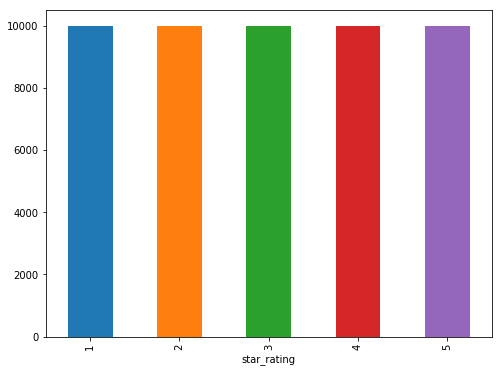

In [8]:
fig = plt.figure(figsize=(8,6))
df.groupby('star_rating').review_body.count().plot.bar()
plt.show()

In [9]:
df['review_body'][2]

"works great, helps alot with smelly dog breath our dog doesn't seem to mind it easy to use reasonably priced all in all very satisfied"

In [12]:
corpus = df['review_body']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=15, 
    stop_words='english', ngram_range=(1,2))
features = vectorizer.fit_transform(corpus).toarray()
labels = df['star_rating']

In [51]:
features.shape

(49999, 13868)

In [52]:
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '04', '05', '08', '10', '10 000', '10 10', '10 11', '10 12', '10 15', '10 34', '10 br', '10 days', '10 feet', '10 hours', '10 minutes', '10 months', '10 seconds', '10 times', '10 year', '10 years', '100', '100 pages', '1000', '101', '1080p', '10th', '11', '110', '12', '12 hours', '12 months', '12 year', '12 years', '120', '1200', '128', '13', '13 year', '130', '14', '14 year', '140', '15', '15 minutes', '15 years', '150', '16', '16 34', '16th', '17', '18', '18 months', '180', '18th', '19', '1930', '1930s', '1940', '1940s', '1950', '1950s', '1960', '1960s', '1970', '1970s', '1980', '1982', '1984', '1985', '1986', '1987', '1989', '1990', '1993', '1994', '1996', '1997', '1998', '1999', '19th', '19th century', '1st', '1st time', '20', '20 30', '20 minutes', '20 years', '200', '200 pages', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2013 br', '2014', '2015', '20th', '20th century', '21', '21st', '

In [53]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for star in range(1,6):
    features_chi2 = chi2(features, labels == star)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' star:".format(star))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '1' star:
  . Most correlated unigrams:
. money
. waste
  . Most correlated bigrams:
. don waste
. waste money
# '2' star:
  . Most correlated unigrams:
. love
. great
  . Most correlated bigrams:
. great product
. works great
# '3' star:
  . Most correlated unigrams:
. okay
. ok
  . Most correlated bigrams:
. just ok
. waste money
# '4' star:
  . Most correlated unigrams:
. enjoyed
. good
  . Most correlated bigrams:
. good book
. waste money
# '5' star:
  . Most correlated unigrams:
. great
. love
  . Most correlated bigrams:
. great product
. highly recommend


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['review_body'], df['star_rating'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [57]:
print(clf.predict(count_vect.transform(["This product is so good! I love it!"])))

[5]


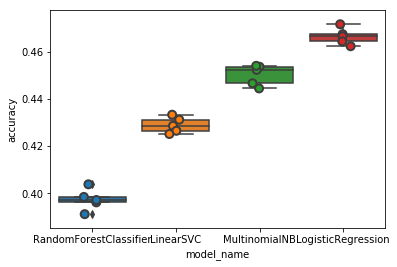

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [63]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(acc)

0.4644666666666667


In [59]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.428949
LogisticRegression        0.466429
MultinomialNB             0.450189
RandomForestClassifier    0.397388
Name: accuracy, dtype: float64

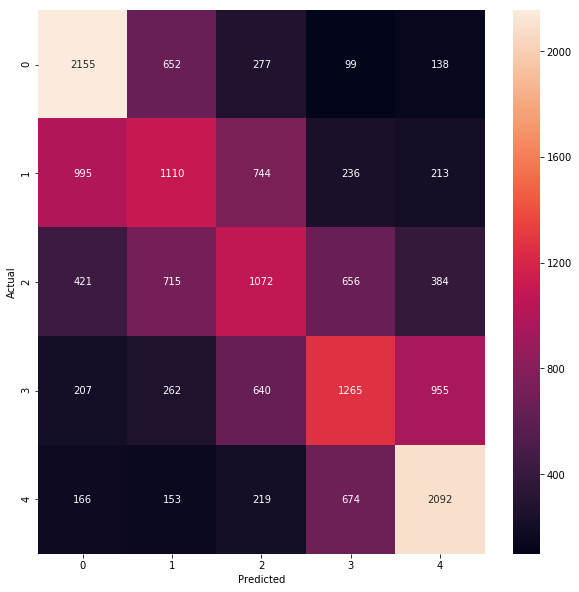

In [60]:
model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.55      0.65      0.59      3321
          2       0.38      0.34      0.36      3298
          3       0.36      0.33      0.35      3248
          4       0.43      0.38      0.40      3329
          5       0.55      0.63      0.59      3304

avg / total       0.46      0.47      0.46     16500



In [76]:
df['binary'] = df.apply(lambda row: 0 if (row['star_rating'] <= 3) else 1, axis=1)
labels = df['binary']

0.8101


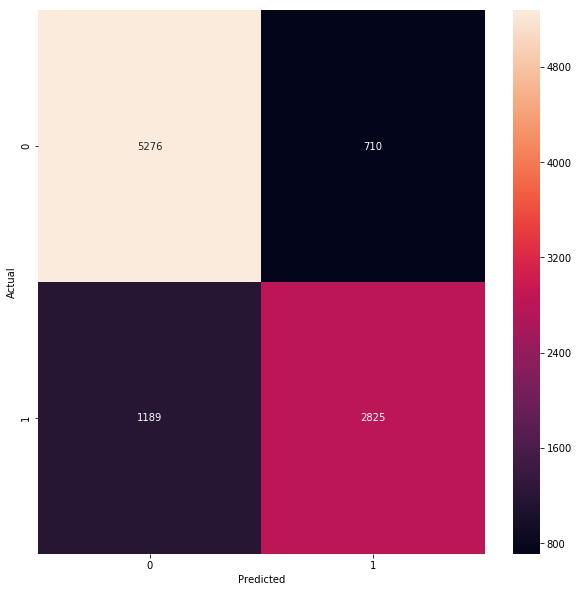

             precision    recall  f1-score   support

          0       0.82      0.88      0.85      5986
          1       0.80      0.70      0.75      4014

avg / total       0.81      0.81      0.81     10000



In [80]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(acc)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred))